In [1]:
import numpy as np
import pandas as pd
import yaml
np.random.seed(42)
import os
from resolve.polynomial_chaos_expansion import PCEMultiFidelityModelVisualizer
import matplotlib.pyplot as plt
import arviz as az

Compiledir: compiledir=./pytensor_cache,mode=FAST_COMPILE,optimizer=None


In [2]:
# Set the path to the yaml settings file here
path_to_settings = "../"
with open(f"{path_to_settings}/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

version       = config_file["path_settings"]["version"]
path_out_cnp  = config_file["path_settings"]["path_out_cnp"]
path_out_cnp  += f"/{version}"
path_out_pce = config_file["path_settings"]["path_out_pce"]
path_out_pce  += f"/{version}"

file_in=f'{path_out_cnp}/cnp_{version}_output.csv'

prefix = f"{path_out_pce}"


In [3]:

if not os.path.exists(path_out_pce):
   os.makedirs(path_out_pce)

# Set parameter name/x_labels -> needs to be consistent with data input file
x_labels        = config_file["simulation_settings"]["theta_headers"]
y_label_lf     = 'y_cnp'
y_label_hf     = 'y_raw'
y_label_plot    = config_file["simulation_settings"]["target_headers_plot"]
x_labels_plot   = config_file["simulation_settings"]["theta_headers_plot"]

# Set parameter boundaries
xmin = config_file["simulation_settings"]["theta_min"]
xmax = config_file["simulation_settings"]["theta_max"]

y_scaling = config_file["simulation_settings"]["y_scaling"]
#pce_visualizer.set_y_scaling(y_scaling)

parameters={}
for i,x in enumerate(x_labels):
   parameters[x]=[xmin[i],xmax[i]]


In [4]:
data=pd.read_csv(file_in)

x_train_hf = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][x_labels].to_numpy()
y_train_hf = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_label_hf].to_numpy()

x_train_lf = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][x_labels].to_numpy()
y_train_lf = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][ y_label_lf].to_numpy()

In [5]:
x_train = [x_train_lf, x_train_hf]
y_train = [y_train_lf, y_train_hf]

In [6]:

degree = [4,1]
fidelities=["lf","hf"]

trace = az.from_netcdf(f"{prefix}/trace.nc")
pce_visualizer= PCEMultiFidelityModelVisualizer(fidelities=fidelities,parameters=parameters,trace=trace,degree=degree)


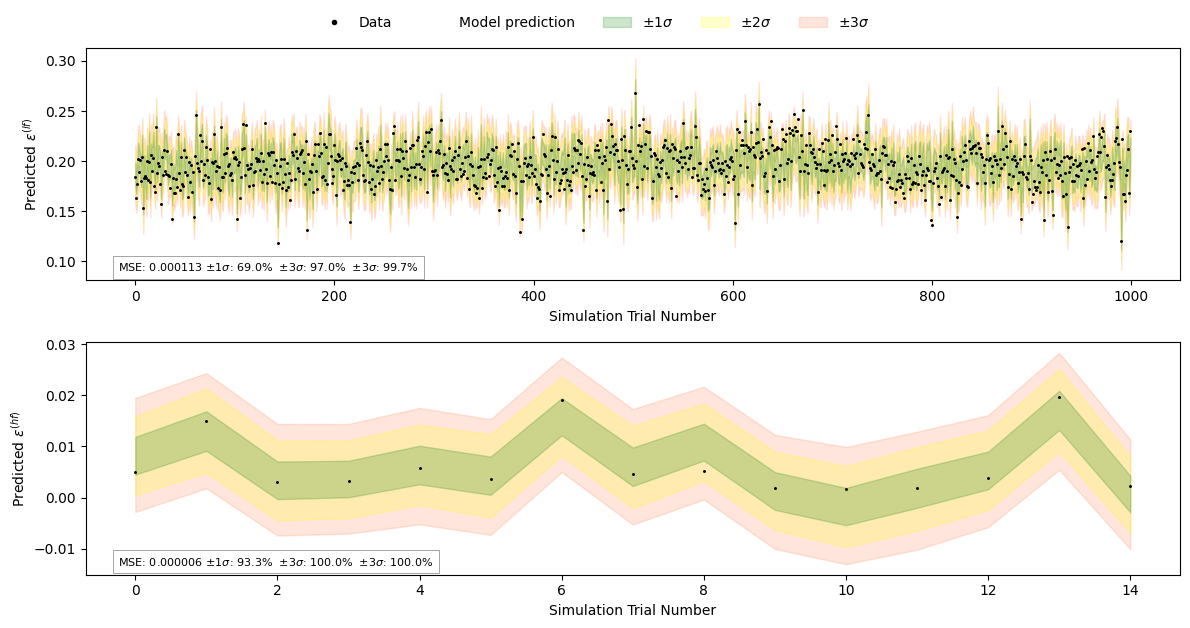

In [7]:
fig = pce_visualizer.plot_validation(x_train,y_train)
fig.savefig(f"{prefix}/validation_train.png",dpi=300, bbox_inches='tight')

In [8]:
x_val_hf = data.loc[(data['fidelity']==1.) & (data['iteration']==-2)][x_labels].to_numpy()
y_val_hf = data.loc[(data['fidelity']==1.) & (data['iteration']==-2)][y_label_hf].to_numpy()

x_val_lf = data.loc[(data['fidelity']==0.) & (data['iteration']==-2)][x_labels].to_numpy()
y_val_lf = data.loc[(data['fidelity']==0.) & (data['iteration']==-2)][ y_label_lf].to_numpy()

x_val = [x_val_lf,x_val_hf]
y_val = [y_val_lf,y_val_hf]


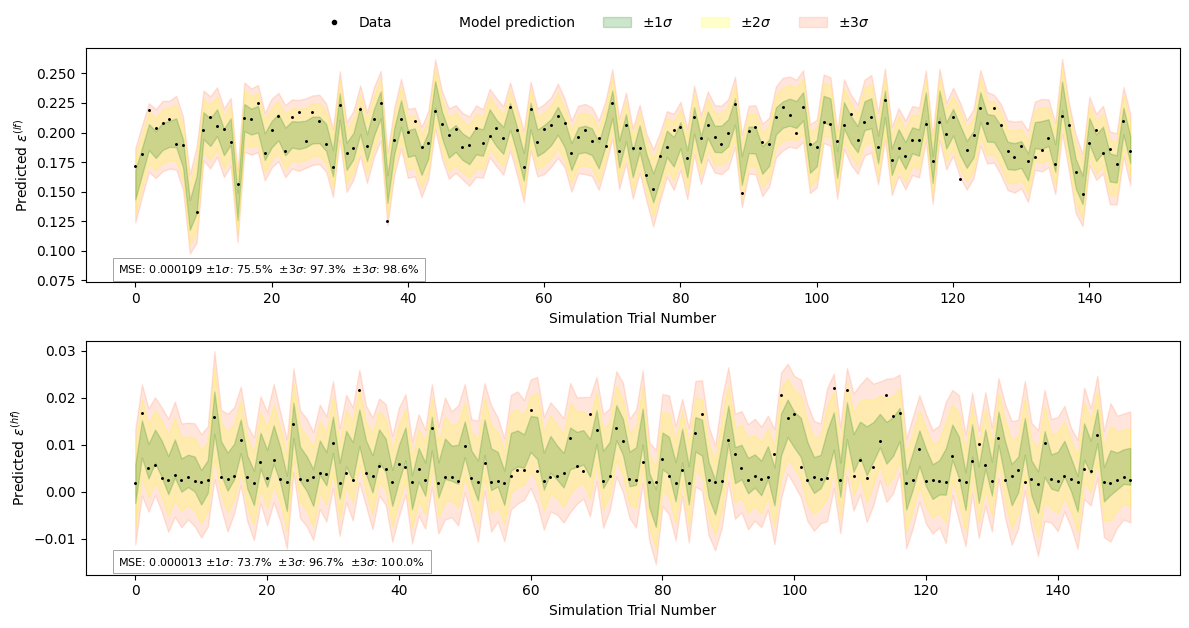

In [9]:
fig = pce_visualizer.plot_validation(x_val,y_val)
fig.savefig(f"{prefix}/validation_val.png",dpi=300, bbox_inches='tight')

In [10]:
df = pd.read_csv(f"{prefix}/table.csv", index_col=False)
mse=pce_visualizer.validate_mse(x_val, y_val)[-1]
df['MSE'] = mse
cov = pce_visualizer.validate_coverage(x_val, y_val)
df["coverage"]="/".join(f"{v:.0f}%" for v in cov[list(cov.keys())[-1]].values())
df.to_csv(f"{prefix}/table.csv", index=False)

In [11]:
df

,lf_sigma_coeffs_prior_type,lf_sigma_coeffs,lf_sigma_y,hf_mu_rho,hf_sigma_rho,hf_sigma_coeffs_prior_type,hf_sigma_coeffs_delta,hf_sigma_y,polynomial_order_lf,polynomial_order_delta_hf,dataset_lf,n_samples,ess_bulk < 100 [%],r_hat > 1.05 [%],p_loo,p_waic,pareto_k > 0.5 [%],BMFI,MSE,coverage
0,default,0.1,0.021755,0.032,0.03028,default,0.1,0.006,4,1,2,8000,0.0,0.0,72.2,70.7,1.1,0.98/0.92/0.91,0.000013,74%/97%/100%


In [12]:
x_val_hf = data.loc[(data['fidelity']==1.) & (data['iteration']<=0)][x_labels].to_numpy()
y_val_hf = data.loc[(data['fidelity']==1.) & (data['iteration']<=0)][y_label_hf].to_numpy()

x_val_lf = data.loc[(data['fidelity']==0.) & (data['iteration']<=0)][x_labels].to_numpy()
y_val_lf = data.loc[(data['fidelity']==0.) & (data['iteration']<=0)][ y_label_lf].to_numpy()

x_val = [x_val_lf,x_val_hf]
y_val = [y_val_lf, y_val_hf]

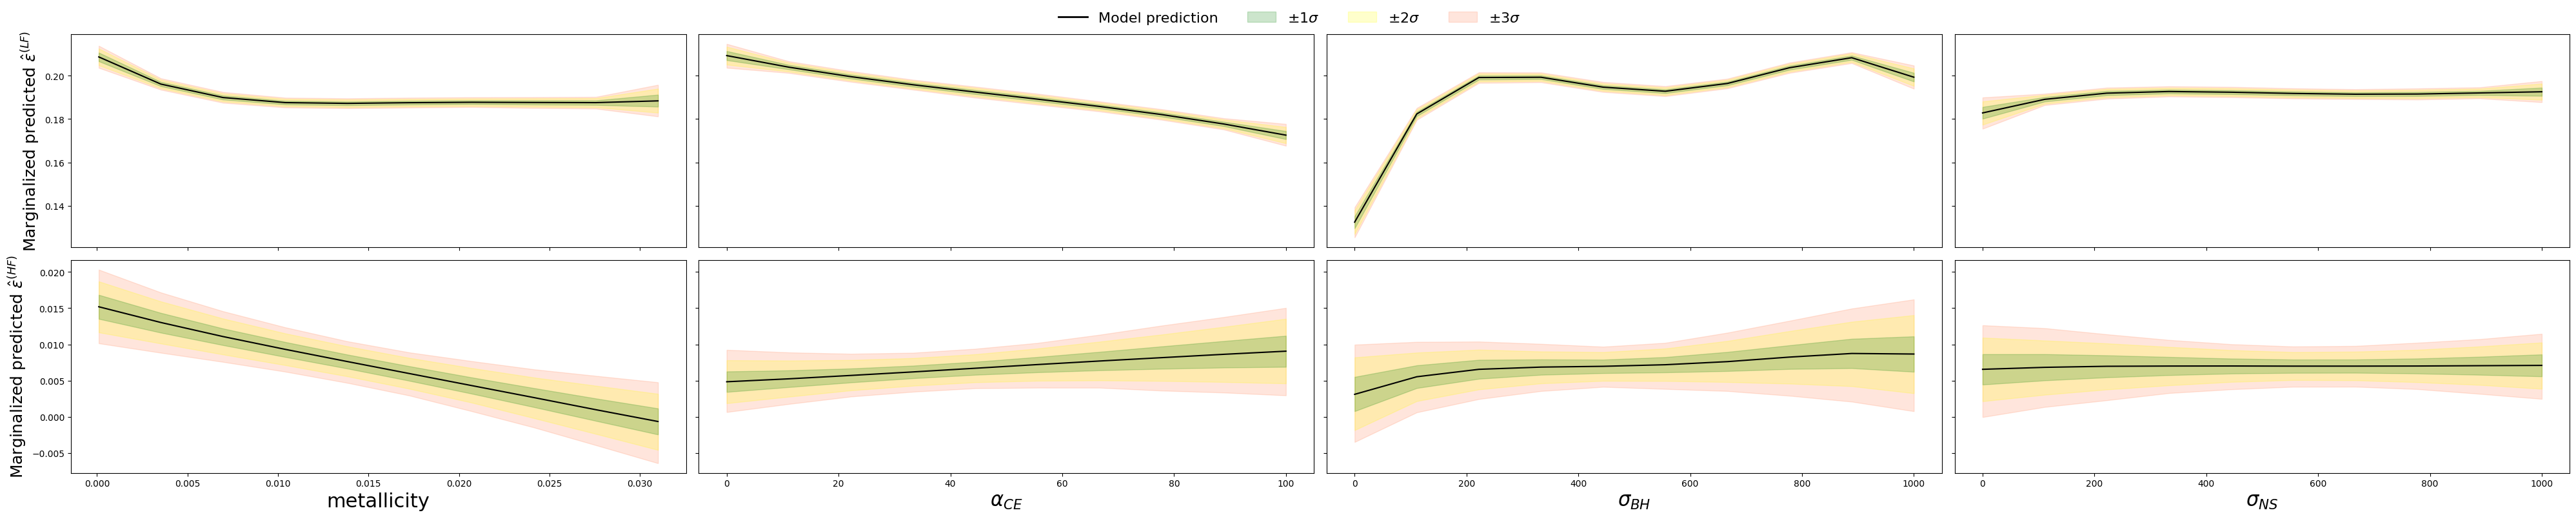

In [17]:
fig = pce_visualizer.plot_marginalized(None,None,grid_steps=10)
axes_list = fig.axes
axes_list[0].set_ylabel(f"Marginalized predicted {y_label_plot}"+"$^{(LF)}$", fontsize=18)
axes_list[4].set_ylabel(f"Marginalized predicted {y_label_plot}"+"$^{(HF)}$", fontsize=18)

nrow = len(fidelities)
ncol = len(x_labels_plot)
for i,l in enumerate(x_labels_plot):
    axes_list[(nrow-1)*ncol+i].set_xlabel(l, fontsize=22)
fig.savefig(f"{prefix}/marginalized.png",dpi=300, bbox_inches='tight')